A basic run-through of sklearn, Tensorflow (prebuilt estimators) and Keras sequential models. 

In [1]:
import sys
sys.path.insert(0, '/Users/kerong/helpers')
from gen_helper import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential 
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization
from keras.utils import to_categorical
from keras import optimizers


Using TensorFlow backend.


https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data

DonorsChoose.org is an online charity that makes it easy to help students in need through school donations. At any time, thousands of teachers in K-12 schools propose projects requesting materials to enhance the education of their students. When a project reaches its funding goal, they ship the materials to the school.

`projects_w_outcomes` contains information about each project, as well as outcomes for each project in the training set. 

We will be predicting whether a project gets fully funded or not.

In [3]:
projects_w_outcomes = pd.read_csv('~/data/kdd-cup-2014-predicting-excitement-at-donors-choose/projects_w_outcomes_20190329_2154.csv')

In [4]:
projects_w_outcomes.columns

Index(['is_exciting', 'at_least_1_teacher_referred_donor', 'fully_funded',
       'at_least_1_green_donation', 'great_chat',
       'three_or_more_non_teacher_referred_donors',
       'one_non_teacher_referred_donor_giving_100_plus',
       'donation_from_thoughtful_donor', 'great_messages_proportion',
       'teacher_referred_count', 'non_teacher_referred_count',
       'school_latitude', 'school_longitude', 'school_state', 'school_metro',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_doubl

In [5]:
projects_w_outcomes.groupby('fully_funded').size().apply(lambda x: x/len(projects_w_outcomes))

fully_funded
0    0.304635
1    0.695365
dtype: float64

In [140]:
x = projects_w_outcomes.drop('fully_funded', axis=1)
y = projects_w_outcomes.fully_funded

In [141]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((415075, 39), (415075,), (204440, 39), (204440,))

Below, we create different classifiers using scikit-learn, tensorflow and keras. 

Properly executed, the modelling process would utilize a hold-out/validation set during the model tuning phase, but for the below illustration purposes we'll only create train and test sets.

# Classification using sklearn's `RandomForestClassifier`

I ran randomized gridsearch CV to find the best hyperparameters for this model, but it's an easy problem and all variations are overfitting. Below is a model with the smallest train/test performance disparity from the variations tried. (The only hyperparameter that seems to drop training performance is num_estimators).  

In [142]:
rf_model = RandomForestClassifier(n_estimators=10, 
                                  min_samples_split=10, 
                                  min_samples_leaf=5, 
                                  max_features='sqrt',
                                  bootstrap=False,
                                  random_state=50,
                                  n_jobs=-1
                                 )


In [143]:
# Add a randint variable to do quick and dirty feature selection

np.random.seed(42)
rand_var = np.random.uniform(0,1)

x_train['rand']=[rand_var]*x_train.shape[0]
x_test['rand']=[rand_var]*x_test.shape[0]

/Users/kerong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kerong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [144]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [145]:
rf_train_score = rf_model.score(x_train, y_train)

print('RF Train Accuracy: ', round(rf_train_score,4))

RF Train Accuracy:  0.9796


In [146]:
rf_test_score = rf_model.score(x_test, y_test)

print('RF Test Accuracy: ', round(rf_test_score,4))

RF Test Accuracy:  0.9573


Let's quickly check feature importances:

In [149]:
feature_importance = rf_model.feature_importances_

In [150]:
feature_names = x_train.columns.tolist()

In [151]:
feature_importance_ix = np.argsort(feature_importance)

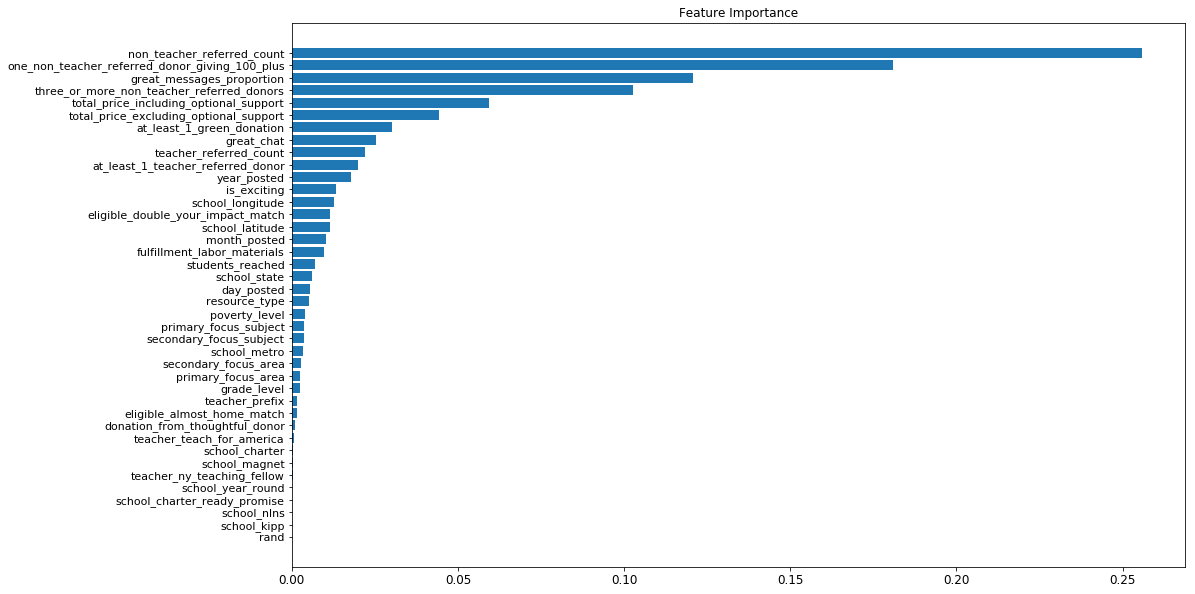

In [152]:
plt.figure(figsize=(16,10))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=11)

plt.barh(range(len(feature_importance_ix)), feature_importance[feature_importance_ix],  align='center')
plt.yticks(range(len(feature_importance_ix)), [feature_names[i] for i in feature_importance_ix])
plt.title('Feature Importance')
plt.show()

Notice that `rand` is coming in at the bottom, which is a good sign. It tells us that all our features are contributing something informative to the model. The most important features relate to non-teacher referrals. This could be interesting...

While `feature_importances_` is a nifty little trick, there are issues with it that have been pointed out, which I frankly have yet to pay close attention to. 
See this post for more details: https://explained.ai/rf-importance/index.html

In [153]:
x_train.drop('rand', axis=1, inplace=True)
x_test.drop('rand', axis=1, inplace=True)

/Users/kerong/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Classification using Tensorflow's `LinearClassifier`


The biggest pain in using Tensorflow's prebuilt estimators is the need to define input functions that feed data into the models. Thankfully, data can be read in from the pandas df form (or numpy array form), but it is still a fiddle. Below I use the `pandas_input_fn` for my input function.

In [154]:
# Define input functions that specify feature names + data types 
# Each returns a tuple: (dictionary of features, target)
# https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn

train_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_train, y=y_train, batch_size=100, num_epochs=50, shuffle=True)
# For evaluation on the training set, we need to define a new input function `train_eval_input_fn` that is similar to `train_input_fn` but only runs for 1 epoch.
train_eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_train, y=y_train, batch_size=100, num_epochs=1, shuffle=True)
test_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_test, y=y_test, batch_size=100, num_epochs=1,shuffle=False)

In [82]:
feature_cols=[]
for i in x.columns.values:
    feature=tf.feature_column.numeric_column(i)
    feature_cols.append(feature)

In [83]:
tf_linear_model = tf.estimator.LinearClassifier(feature_columns=feature_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmpetehdcpc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a46cf46d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [84]:
tf_linear_model.train(input_fn=train_input_fn)#, steps=10000) 
# Number of steps is unncessary since we specified batch size and number of epochs in the input functions above

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmpetehdcpc/model.ckpt.
INFO:tensorflow:loss = 69.31472, step = 1
INFO:tensorflow:global_step/sec: 155.696
INFO:tensorflow:loss = 839.95776, step = 101 (0.642 sec)
INFO:tensorflow:global_step/sec: 253.689
INFO:tensorflow:loss = 151.17857, step = 201 (0.394 sec)
INFO:tensorflow:global_step/sec: 249.754
INFO:tensorflow:loss = 515.3064, step = 301 (0.400 sec)
INFO:tensorf

INFO:tensorflow:loss = 28.178646, step = 6601 (0.409 sec)
INFO:tensorflow:global_step/sec: 248.716
INFO:tensorflow:loss = 35.46666, step = 6701 (0.402 sec)
INFO:tensorflow:global_step/sec: 249.355
INFO:tensorflow:loss = 31.439468, step = 6801 (0.401 sec)
INFO:tensorflow:global_step/sec: 246.26
INFO:tensorflow:loss = 24.603039, step = 6901 (0.406 sec)
INFO:tensorflow:global_step/sec: 245.712
INFO:tensorflow:loss = 527.097, step = 7001 (0.407 sec)
INFO:tensorflow:global_step/sec: 235.304
INFO:tensorflow:loss = 268.94043, step = 7101 (0.425 sec)
INFO:tensorflow:global_step/sec: 244.398
INFO:tensorflow:loss = 214.57, step = 7201 (0.409 sec)
INFO:tensorflow:global_step/sec: 240.357
INFO:tensorflow:loss = 39.01579, step = 7301 (0.416 sec)
INFO:tensorflow:global_step/sec: 241.825
INFO:tensorflow:loss = 44.12572, step = 7401 (0.414 sec)
INFO:tensorflow:global_step/sec: 236.26
INFO:tensorflow:loss = 25.953928, step = 7501 (0.423 sec)
INFO:tensorflow:global_step/sec: 238.1
INFO:tensorflow:loss =

INFO:tensorflow:loss = 21.829483, step = 14901 (0.423 sec)
INFO:tensorflow:global_step/sec: 214.972
INFO:tensorflow:loss = 64.82483, step = 15001 (0.465 sec)
INFO:tensorflow:global_step/sec: 234.897
INFO:tensorflow:loss = 41.968143, step = 15101 (0.426 sec)
INFO:tensorflow:global_step/sec: 239.147
INFO:tensorflow:loss = 19.616106, step = 15201 (0.418 sec)
INFO:tensorflow:global_step/sec: 239.256
INFO:tensorflow:loss = 64.76531, step = 15301 (0.418 sec)
INFO:tensorflow:global_step/sec: 235.261
INFO:tensorflow:loss = 27.202986, step = 15401 (0.425 sec)
INFO:tensorflow:global_step/sec: 233.826
INFO:tensorflow:loss = 21.491962, step = 15501 (0.428 sec)
INFO:tensorflow:global_step/sec: 232.448
INFO:tensorflow:loss = 81.5056, step = 15601 (0.430 sec)
INFO:tensorflow:global_step/sec: 238.998
INFO:tensorflow:loss = 43.049854, step = 15701 (0.419 sec)
INFO:tensorflow:global_step/sec: 239.453
INFO:tensorflow:loss = 58.304253, step = 15801 (0.418 sec)
INFO:tensorflow:global_step/sec: 239.249
INFO

INFO:tensorflow:global_step/sec: 233.764
INFO:tensorflow:loss = 14.11079, step = 23201 (0.428 sec)
INFO:tensorflow:global_step/sec: 225.166
INFO:tensorflow:loss = 18.162819, step = 23301 (0.444 sec)
INFO:tensorflow:global_step/sec: 222.03
INFO:tensorflow:loss = 11.751885, step = 23401 (0.450 sec)
INFO:tensorflow:global_step/sec: 241.27
INFO:tensorflow:loss = 25.406487, step = 23501 (0.414 sec)
INFO:tensorflow:global_step/sec: 231.771
INFO:tensorflow:loss = 341.71893, step = 23601 (0.431 sec)
INFO:tensorflow:global_step/sec: 232.994
INFO:tensorflow:loss = 103.21782, step = 23701 (0.429 sec)
INFO:tensorflow:global_step/sec: 234.059
INFO:tensorflow:loss = 121.368774, step = 23801 (0.427 sec)
INFO:tensorflow:global_step/sec: 228.615
INFO:tensorflow:loss = 50.41324, step = 23901 (0.437 sec)
INFO:tensorflow:global_step/sec: 230.419
INFO:tensorflow:loss = 39.56676, step = 24001 (0.434 sec)
INFO:tensorflow:global_step/sec: 232.551
INFO:tensorflow:loss = 18.310392, step = 24101 (0.430 sec)
INFO

INFO:tensorflow:loss = 76.690025, step = 31401 (0.410 sec)
INFO:tensorflow:global_step/sec: 243.266
INFO:tensorflow:loss = 24.936735, step = 31501 (0.411 sec)
INFO:tensorflow:global_step/sec: 240.208
INFO:tensorflow:loss = 17.729113, step = 31601 (0.417 sec)
INFO:tensorflow:global_step/sec: 242.228
INFO:tensorflow:loss = 28.204395, step = 31701 (0.413 sec)
INFO:tensorflow:global_step/sec: 232.657
INFO:tensorflow:loss = 44.074955, step = 31801 (0.430 sec)
INFO:tensorflow:global_step/sec: 233.772
INFO:tensorflow:loss = 114.56508, step = 31901 (0.428 sec)
INFO:tensorflow:global_step/sec: 236.819
INFO:tensorflow:loss = 109.3651, step = 32001 (0.422 sec)
INFO:tensorflow:global_step/sec: 236.121
INFO:tensorflow:loss = 79.96942, step = 32101 (0.423 sec)
INFO:tensorflow:global_step/sec: 229.823
INFO:tensorflow:loss = 36.116158, step = 32201 (0.435 sec)
INFO:tensorflow:global_step/sec: 230.181
INFO:tensorflow:loss = 28.20101, step = 32301 (0.435 sec)
INFO:tensorflow:global_step/sec: 232.049
INF

INFO:tensorflow:global_step/sec: 229.963
INFO:tensorflow:loss = 15.603389, step = 39701 (0.435 sec)
INFO:tensorflow:global_step/sec: 228.412
INFO:tensorflow:loss = 21.64364, step = 39801 (0.438 sec)
INFO:tensorflow:global_step/sec: 230.764
INFO:tensorflow:loss = 151.4841, step = 39901 (0.433 sec)
INFO:tensorflow:global_step/sec: 233.296
INFO:tensorflow:loss = 73.89072, step = 40001 (0.428 sec)
INFO:tensorflow:global_step/sec: 235.9
INFO:tensorflow:loss = 64.33151, step = 40101 (0.424 sec)
INFO:tensorflow:global_step/sec: 228.68
INFO:tensorflow:loss = 35.760883, step = 40201 (0.437 sec)
INFO:tensorflow:global_step/sec: 229.65
INFO:tensorflow:loss = 18.673523, step = 40301 (0.436 sec)
INFO:tensorflow:global_step/sec: 233.788
INFO:tensorflow:loss = 18.040138, step = 40401 (0.427 sec)
INFO:tensorflow:global_step/sec: 230.893
INFO:tensorflow:loss = 38.562614, step = 40501 (0.434 sec)
INFO:tensorflow:global_step/sec: 236.612
INFO:tensorflow:loss = 24.826456, step = 40601 (0.422 sec)
INFO:ten

INFO:tensorflow:loss = 36.736973, step = 47901 (0.428 sec)
INFO:tensorflow:global_step/sec: 229.752
INFO:tensorflow:loss = 15.640203, step = 48001 (0.435 sec)
INFO:tensorflow:global_step/sec: 222.347
INFO:tensorflow:loss = 18.894253, step = 48101 (0.450 sec)
INFO:tensorflow:global_step/sec: 222.249
INFO:tensorflow:loss = 48.324413, step = 48201 (0.450 sec)
INFO:tensorflow:global_step/sec: 224.677
INFO:tensorflow:loss = 31.458231, step = 48301 (0.445 sec)
INFO:tensorflow:global_step/sec: 219.568
INFO:tensorflow:loss = 19.935045, step = 48401 (0.455 sec)
INFO:tensorflow:global_step/sec: 225.656
INFO:tensorflow:loss = 36.08077, step = 48501 (0.443 sec)
INFO:tensorflow:global_step/sec: 234.53
INFO:tensorflow:loss = 108.53241, step = 48601 (0.426 sec)
INFO:tensorflow:global_step/sec: 236.064
INFO:tensorflow:loss = 26.06961, step = 48701 (0.424 sec)
INFO:tensorflow:global_step/sec: 241.151
INFO:tensorflow:loss = 21.972963, step = 48801 (0.415 sec)
INFO:tensorflow:global_step/sec: 226.167
INF

INFO:tensorflow:global_step/sec: 232.467
INFO:tensorflow:loss = 28.629446, step = 56201 (0.430 sec)
INFO:tensorflow:global_step/sec: 217.568
INFO:tensorflow:loss = 36.82219, step = 56301 (0.460 sec)
INFO:tensorflow:global_step/sec: 238.642
INFO:tensorflow:loss = 18.813349, step = 56401 (0.419 sec)
INFO:tensorflow:global_step/sec: 233.952
INFO:tensorflow:loss = 24.847181, step = 56501 (0.427 sec)
INFO:tensorflow:global_step/sec: 237.069
INFO:tensorflow:loss = 26.664328, step = 56601 (0.422 sec)
INFO:tensorflow:global_step/sec: 230.777
INFO:tensorflow:loss = 51.111927, step = 56701 (0.433 sec)
INFO:tensorflow:global_step/sec: 206.94
INFO:tensorflow:loss = 34.2328, step = 56801 (0.483 sec)
INFO:tensorflow:global_step/sec: 239.005
INFO:tensorflow:loss = 24.528019, step = 56901 (0.419 sec)
INFO:tensorflow:global_step/sec: 225.524
INFO:tensorflow:loss = 64.534805, step = 57001 (0.443 sec)
INFO:tensorflow:global_step/sec: 223.627
INFO:tensorflow:loss = 18.378574, step = 57101 (0.447 sec)
INFO

INFO:tensorflow:loss = 33.38273, step = 64401 (0.431 sec)
INFO:tensorflow:global_step/sec: 230.147
INFO:tensorflow:loss = 25.685686, step = 64501 (0.434 sec)
INFO:tensorflow:global_step/sec: 230.819
INFO:tensorflow:loss = 31.293032, step = 64601 (0.434 sec)
INFO:tensorflow:global_step/sec: 246.127
INFO:tensorflow:loss = 36.767654, step = 64701 (0.406 sec)
INFO:tensorflow:global_step/sec: 241.468
INFO:tensorflow:loss = 151.65253, step = 64801 (0.414 sec)
INFO:tensorflow:global_step/sec: 232.938
INFO:tensorflow:loss = 57.836754, step = 64901 (0.429 sec)
INFO:tensorflow:global_step/sec: 223.934
INFO:tensorflow:loss = 56.659103, step = 65001 (0.447 sec)
INFO:tensorflow:global_step/sec: 234.21
INFO:tensorflow:loss = 52.955544, step = 65101 (0.427 sec)
INFO:tensorflow:global_step/sec: 236.645
INFO:tensorflow:loss = 25.408585, step = 65201 (0.422 sec)
INFO:tensorflow:global_step/sec: 240.542
INFO:tensorflow:loss = 22.121065, step = 65301 (0.416 sec)
INFO:tensorflow:global_step/sec: 236.08
INF

INFO:tensorflow:global_step/sec: 227.004
INFO:tensorflow:loss = 28.73588, step = 72701 (0.441 sec)
INFO:tensorflow:global_step/sec: 220.29
INFO:tensorflow:loss = 37.211926, step = 72801 (0.454 sec)
INFO:tensorflow:global_step/sec: 218.87
INFO:tensorflow:loss = 45.305683, step = 72901 (0.457 sec)
INFO:tensorflow:global_step/sec: 219.394
INFO:tensorflow:loss = 19.51931, step = 73001 (0.455 sec)
INFO:tensorflow:global_step/sec: 240.97
INFO:tensorflow:loss = 29.196373, step = 73101 (0.415 sec)
INFO:tensorflow:global_step/sec: 228.067
INFO:tensorflow:loss = 39.673378, step = 73201 (0.439 sec)
INFO:tensorflow:global_step/sec: 243.458
INFO:tensorflow:loss = 20.855192, step = 73301 (0.411 sec)
INFO:tensorflow:global_step/sec: 242.118
INFO:tensorflow:loss = 24.69818, step = 73401 (0.413 sec)
INFO:tensorflow:global_step/sec: 240.213
INFO:tensorflow:loss = 49.05026, step = 73501 (0.416 sec)
INFO:tensorflow:global_step/sec: 245.962
INFO:tensorflow:loss = 36.978497, step = 73601 (0.407 sec)
INFO:te

INFO:tensorflow:loss = 20.477087, step = 80901 (0.412 sec)
INFO:tensorflow:global_step/sec: 233.756
INFO:tensorflow:loss = 39.573833, step = 81001 (0.428 sec)
INFO:tensorflow:global_step/sec: 227.488
INFO:tensorflow:loss = 33.727367, step = 81101 (0.440 sec)
INFO:tensorflow:global_step/sec: 220.396
INFO:tensorflow:loss = 29.454798, step = 81201 (0.454 sec)
INFO:tensorflow:global_step/sec: 238.6
INFO:tensorflow:loss = 28.751247, step = 81301 (0.419 sec)
INFO:tensorflow:global_step/sec: 235.329
INFO:tensorflow:loss = 23.52631, step = 81401 (0.425 sec)
INFO:tensorflow:global_step/sec: 236.806
INFO:tensorflow:loss = 20.340912, step = 81501 (0.422 sec)
INFO:tensorflow:global_step/sec: 233.18
INFO:tensorflow:loss = 21.427067, step = 81601 (0.429 sec)
INFO:tensorflow:global_step/sec: 221.033
INFO:tensorflow:loss = 69.341805, step = 81701 (0.453 sec)
INFO:tensorflow:global_step/sec: 225.718
INFO:tensorflow:loss = 14.034887, step = 81801 (0.443 sec)
INFO:tensorflow:global_step/sec: 223.81
INFO:

INFO:tensorflow:global_step/sec: 224.114
INFO:tensorflow:loss = 15.77458, step = 89201 (0.446 sec)
INFO:tensorflow:global_step/sec: 229.9
INFO:tensorflow:loss = 26.000439, step = 89301 (0.435 sec)
INFO:tensorflow:global_step/sec: 222.252
INFO:tensorflow:loss = 52.244606, step = 89401 (0.450 sec)
INFO:tensorflow:global_step/sec: 224.014
INFO:tensorflow:loss = 32.47468, step = 89501 (0.447 sec)
INFO:tensorflow:global_step/sec: 234.224
INFO:tensorflow:loss = 25.317673, step = 89601 (0.427 sec)
INFO:tensorflow:global_step/sec: 238.779
INFO:tensorflow:loss = 80.93506, step = 89701 (0.419 sec)
INFO:tensorflow:global_step/sec: 230.452
INFO:tensorflow:loss = 81.93695, step = 89801 (0.434 sec)
INFO:tensorflow:global_step/sec: 226.729
INFO:tensorflow:loss = 31.697283, step = 89901 (0.441 sec)
INFO:tensorflow:global_step/sec: 245.919
INFO:tensorflow:loss = 33.69659, step = 90001 (0.406 sec)
INFO:tensorflow:global_step/sec: 238.119
INFO:tensorflow:loss = 27.066172, step = 90101 (0.420 sec)
INFO:te

INFO:tensorflow:loss = 18.230806, step = 97401 (0.418 sec)
INFO:tensorflow:global_step/sec: 237.327
INFO:tensorflow:loss = 21.723585, step = 97501 (0.421 sec)
INFO:tensorflow:global_step/sec: 237.726
INFO:tensorflow:loss = 34.840275, step = 97601 (0.421 sec)
INFO:tensorflow:global_step/sec: 241.379
INFO:tensorflow:loss = 38.442287, step = 97701 (0.414 sec)
INFO:tensorflow:global_step/sec: 244.652
INFO:tensorflow:loss = 17.622494, step = 97801 (0.409 sec)
INFO:tensorflow:global_step/sec: 243.33
INFO:tensorflow:loss = 54.91634, step = 97901 (0.411 sec)
INFO:tensorflow:global_step/sec: 230.932
INFO:tensorflow:loss = 34.42632, step = 98001 (0.433 sec)
INFO:tensorflow:global_step/sec: 240.836
INFO:tensorflow:loss = 16.018642, step = 98101 (0.415 sec)
INFO:tensorflow:global_step/sec: 237.336
INFO:tensorflow:loss = 17.752617, step = 98201 (0.422 sec)
INFO:tensorflow:global_step/sec: 236.679
INFO:tensorflow:loss = 19.461334, step = 98301 (0.422 sec)
INFO:tensorflow:global_step/sec: 233.952
INF

INFO:tensorflow:loss = 36.366295, step = 105601 (0.422 sec)
INFO:tensorflow:global_step/sec: 243.693
INFO:tensorflow:loss = 14.056883, step = 105701 (0.410 sec)
INFO:tensorflow:global_step/sec: 242.538
INFO:tensorflow:loss = 27.774332, step = 105801 (0.412 sec)
INFO:tensorflow:global_step/sec: 237.417
INFO:tensorflow:loss = 17.567049, step = 105901 (0.421 sec)
INFO:tensorflow:global_step/sec: 235.72
INFO:tensorflow:loss = 26.463793, step = 106001 (0.424 sec)
INFO:tensorflow:global_step/sec: 243.569
INFO:tensorflow:loss = 27.141851, step = 106101 (0.411 sec)
INFO:tensorflow:global_step/sec: 242.036
INFO:tensorflow:loss = 22.12435, step = 106201 (0.413 sec)
INFO:tensorflow:global_step/sec: 242.568
INFO:tensorflow:loss = 191.22992, step = 106301 (0.412 sec)
INFO:tensorflow:global_step/sec: 240.051
INFO:tensorflow:loss = 93.814285, step = 106401 (0.417 sec)
INFO:tensorflow:global_step/sec: 227.868
INFO:tensorflow:loss = 23.164225, step = 106501 (0.439 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 232.005
INFO:tensorflow:loss = 23.652983, step = 113801 (0.431 sec)
INFO:tensorflow:global_step/sec: 243.708
INFO:tensorflow:loss = 28.469044, step = 113901 (0.410 sec)
INFO:tensorflow:global_step/sec: 243.654
INFO:tensorflow:loss = 51.101078, step = 114001 (0.411 sec)
INFO:tensorflow:global_step/sec: 240.683
INFO:tensorflow:loss = 21.991259, step = 114101 (0.415 sec)
INFO:tensorflow:global_step/sec: 233.521
INFO:tensorflow:loss = 21.616577, step = 114201 (0.428 sec)
INFO:tensorflow:global_step/sec: 234.616
INFO:tensorflow:loss = 26.470057, step = 114301 (0.426 sec)
INFO:tensorflow:global_step/sec: 234.553
INFO:tensorflow:loss = 20.064188, step = 114401 (0.426 sec)
INFO:tensorflow:global_step/sec: 236.087
INFO:tensorflow:loss = 31.077194, step = 114501 (0.423 sec)
INFO:tensorflow:global_step/sec: 234.238
INFO:tensorflow:loss = 24.290699, step = 114601 (0.427 sec)
INFO:tensorflow:global_step/sec: 223.501
INFO:tensorflow:loss = 28.772215, step = 114701 (0

INFO:tensorflow:loss = 22.275715, step = 121901 (0.410 sec)
INFO:tensorflow:global_step/sec: 244.304
INFO:tensorflow:loss = 64.04288, step = 122001 (0.409 sec)
INFO:tensorflow:global_step/sec: 245.651
INFO:tensorflow:loss = 38.170124, step = 122101 (0.407 sec)
INFO:tensorflow:global_step/sec: 242.681
INFO:tensorflow:loss = 32.933113, step = 122201 (0.412 sec)
INFO:tensorflow:global_step/sec: 242.779
INFO:tensorflow:loss = 21.69879, step = 122301 (0.412 sec)
INFO:tensorflow:global_step/sec: 244.411
INFO:tensorflow:loss = 27.380526, step = 122401 (0.409 sec)
INFO:tensorflow:global_step/sec: 235.134
INFO:tensorflow:loss = 16.033592, step = 122501 (0.425 sec)
INFO:tensorflow:global_step/sec: 232.335
INFO:tensorflow:loss = 35.283077, step = 122601 (0.431 sec)
INFO:tensorflow:global_step/sec: 236.806
INFO:tensorflow:loss = 111.27616, step = 122701 (0.422 sec)
INFO:tensorflow:global_step/sec: 236.197
INFO:tensorflow:loss = 32.818024, step = 122801 (0.423 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 241.891
INFO:tensorflow:loss = 19.836937, step = 130101 (0.413 sec)
INFO:tensorflow:global_step/sec: 244.467
INFO:tensorflow:loss = 45.111736, step = 130201 (0.409 sec)
INFO:tensorflow:global_step/sec: 246.014
INFO:tensorflow:loss = 35.613323, step = 130301 (0.407 sec)
INFO:tensorflow:global_step/sec: 240.985
INFO:tensorflow:loss = 16.562069, step = 130401 (0.415 sec)
INFO:tensorflow:global_step/sec: 231.762
INFO:tensorflow:loss = 34.14344, step = 130501 (0.431 sec)
INFO:tensorflow:global_step/sec: 232.198
INFO:tensorflow:loss = 38.247566, step = 130601 (0.431 sec)
INFO:tensorflow:global_step/sec: 244.859
INFO:tensorflow:loss = 24.326406, step = 130701 (0.409 sec)
INFO:tensorflow:global_step/sec: 237.592
INFO:tensorflow:loss = 24.321285, step = 130801 (0.421 sec)
INFO:tensorflow:global_step/sec: 238.286
INFO:tensorflow:loss = 13.024447, step = 130901 (0.419 sec)
INFO:tensorflow:global_step/sec: 243.309
INFO:tensorflow:loss = 110.81941, step = 131001 (0.

INFO:tensorflow:loss = 29.072098, step = 138201 (0.416 sec)
INFO:tensorflow:global_step/sec: 239.795
INFO:tensorflow:loss = 53.636852, step = 138301 (0.417 sec)
INFO:tensorflow:global_step/sec: 247.599
INFO:tensorflow:loss = 24.775782, step = 138401 (0.404 sec)
INFO:tensorflow:global_step/sec: 235.263
INFO:tensorflow:loss = 26.489357, step = 138501 (0.425 sec)
INFO:tensorflow:global_step/sec: 242.75
INFO:tensorflow:loss = 2055.7373, step = 138601 (0.412 sec)
INFO:tensorflow:global_step/sec: 242.238
INFO:tensorflow:loss = 2059.7532, step = 138701 (0.413 sec)
INFO:tensorflow:global_step/sec: 239.244
INFO:tensorflow:loss = 3912.404, step = 138801 (0.418 sec)
INFO:tensorflow:global_step/sec: 243.504
INFO:tensorflow:loss = 1267.4357, step = 138901 (0.411 sec)
INFO:tensorflow:global_step/sec: 236.935
INFO:tensorflow:loss = 605.60834, step = 139001 (0.422 sec)
INFO:tensorflow:global_step/sec: 234.159
INFO:tensorflow:loss = 633.47815, step = 139101 (0.427 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 231.861
INFO:tensorflow:loss = 28.184414, step = 146301 (0.431 sec)
INFO:tensorflow:global_step/sec: 231.302
INFO:tensorflow:loss = 18.972322, step = 146401 (0.433 sec)
INFO:tensorflow:global_step/sec: 239.805
INFO:tensorflow:loss = 32.602528, step = 146501 (0.417 sec)
INFO:tensorflow:global_step/sec: 238.72
INFO:tensorflow:loss = 29.365719, step = 146601 (0.419 sec)
INFO:tensorflow:global_step/sec: 231.609
INFO:tensorflow:loss = 8.982932, step = 146701 (0.432 sec)
INFO:tensorflow:global_step/sec: 216.846
INFO:tensorflow:loss = 40.442135, step = 146801 (0.461 sec)
INFO:tensorflow:global_step/sec: 233.428
INFO:tensorflow:loss = 45.17199, step = 146901 (0.428 sec)
INFO:tensorflow:global_step/sec: 240.09
INFO:tensorflow:loss = 29.966219, step = 147001 (0.417 sec)
INFO:tensorflow:global_step/sec: 235.629
INFO:tensorflow:loss = 53.375957, step = 147101 (0.424 sec)
INFO:tensorflow:global_step/sec: 242.656
INFO:tensorflow:loss = 37.810127, step = 147201 (0.412

INFO:tensorflow:loss = 54.072937, step = 154401 (0.442 sec)
INFO:tensorflow:global_step/sec: 227.091
INFO:tensorflow:loss = 37.865543, step = 154501 (0.440 sec)
INFO:tensorflow:global_step/sec: 233.218
INFO:tensorflow:loss = 29.849684, step = 154601 (0.429 sec)
INFO:tensorflow:global_step/sec: 233.42
INFO:tensorflow:loss = 28.1785, step = 154701 (0.428 sec)
INFO:tensorflow:global_step/sec: 235.353
INFO:tensorflow:loss = 24.267134, step = 154801 (0.425 sec)
INFO:tensorflow:global_step/sec: 235.974
INFO:tensorflow:loss = 26.630833, step = 154901 (0.424 sec)
INFO:tensorflow:global_step/sec: 232.474
INFO:tensorflow:loss = 12.462749, step = 155001 (0.430 sec)
INFO:tensorflow:global_step/sec: 241.882
INFO:tensorflow:loss = 16.846167, step = 155101 (0.414 sec)
INFO:tensorflow:global_step/sec: 244.406
INFO:tensorflow:loss = 26.539955, step = 155201 (0.409 sec)
INFO:tensorflow:global_step/sec: 246.755
INFO:tensorflow:loss = 23.86976, step = 155301 (0.405 sec)
INFO:tensorflow:global_step/sec: 23

INFO:tensorflow:global_step/sec: 223.441
INFO:tensorflow:loss = 44.06938, step = 162601 (0.447 sec)
INFO:tensorflow:global_step/sec: 225.667
INFO:tensorflow:loss = 21.905191, step = 162701 (0.443 sec)
INFO:tensorflow:global_step/sec: 243.617
INFO:tensorflow:loss = 23.52806, step = 162801 (0.411 sec)
INFO:tensorflow:global_step/sec: 236.086
INFO:tensorflow:loss = 30.827799, step = 162901 (0.423 sec)
INFO:tensorflow:global_step/sec: 227.602
INFO:tensorflow:loss = 42.995514, step = 163001 (0.439 sec)
INFO:tensorflow:global_step/sec: 234.045
INFO:tensorflow:loss = 37.153477, step = 163101 (0.427 sec)
INFO:tensorflow:global_step/sec: 233.374
INFO:tensorflow:loss = 22.580095, step = 163201 (0.429 sec)
INFO:tensorflow:global_step/sec: 229.665
INFO:tensorflow:loss = 24.955856, step = 163301 (0.435 sec)
INFO:tensorflow:global_step/sec: 217.716
INFO:tensorflow:loss = 31.52989, step = 163401 (0.459 sec)
INFO:tensorflow:global_step/sec: 224.111
INFO:tensorflow:loss = 27.100136, step = 163501 (0.44

INFO:tensorflow:global_step/sec: 242.109
INFO:tensorflow:loss = 38.532784, step = 170801 (0.413 sec)
INFO:tensorflow:global_step/sec: 238.684
INFO:tensorflow:loss = 27.640842, step = 170901 (0.419 sec)
INFO:tensorflow:global_step/sec: 231.807
INFO:tensorflow:loss = 51.416565, step = 171001 (0.432 sec)
INFO:tensorflow:global_step/sec: 226.968
INFO:tensorflow:loss = 58.12678, step = 171101 (0.441 sec)
INFO:tensorflow:global_step/sec: 235.295
INFO:tensorflow:loss = 26.245876, step = 171201 (0.425 sec)
INFO:tensorflow:global_step/sec: 235.551
INFO:tensorflow:loss = 21.107351, step = 171301 (0.425 sec)
INFO:tensorflow:global_step/sec: 234.127
INFO:tensorflow:loss = 10.636758, step = 171401 (0.427 sec)
INFO:tensorflow:global_step/sec: 236.43
INFO:tensorflow:loss = 21.925903, step = 171501 (0.423 sec)
INFO:tensorflow:global_step/sec: 229.103
INFO:tensorflow:loss = 19.865587, step = 171601 (0.436 sec)
INFO:tensorflow:global_step/sec: 235.829
INFO:tensorflow:loss = 34.38737, step = 171701 (0.42

INFO:tensorflow:loss = 29.190416, step = 178901 (0.414 sec)
INFO:tensorflow:global_step/sec: 239.529
INFO:tensorflow:loss = 29.104612, step = 179001 (0.418 sec)
INFO:tensorflow:global_step/sec: 245.415
INFO:tensorflow:loss = 37.892612, step = 179101 (0.407 sec)
INFO:tensorflow:global_step/sec: 239.387
INFO:tensorflow:loss = 39.496162, step = 179201 (0.418 sec)
INFO:tensorflow:global_step/sec: 234.043
INFO:tensorflow:loss = 46.49676, step = 179301 (0.427 sec)
INFO:tensorflow:global_step/sec: 236.629
INFO:tensorflow:loss = 50.68721, step = 179401 (0.423 sec)
INFO:tensorflow:global_step/sec: 232.674
INFO:tensorflow:loss = 38.64789, step = 179501 (0.430 sec)
INFO:tensorflow:global_step/sec: 231.964
INFO:tensorflow:loss = 16.936764, step = 179601 (0.431 sec)
INFO:tensorflow:global_step/sec: 243.046
INFO:tensorflow:loss = 32.57792, step = 179701 (0.411 sec)
INFO:tensorflow:global_step/sec: 239.833
INFO:tensorflow:loss = 15.4314995, step = 179801 (0.417 sec)
INFO:tensorflow:global_step/sec: 2

INFO:tensorflow:global_step/sec: 247.429
INFO:tensorflow:loss = 45.332584, step = 187101 (0.404 sec)
INFO:tensorflow:global_step/sec: 243.525
INFO:tensorflow:loss = 31.447208, step = 187201 (0.410 sec)
INFO:tensorflow:global_step/sec: 233.672
INFO:tensorflow:loss = 16.561323, step = 187301 (0.428 sec)
INFO:tensorflow:global_step/sec: 237.676
INFO:tensorflow:loss = 17.950918, step = 187401 (0.421 sec)
INFO:tensorflow:global_step/sec: 241.732
INFO:tensorflow:loss = 43.44124, step = 187501 (0.414 sec)
INFO:tensorflow:global_step/sec: 226.584
INFO:tensorflow:loss = 23.565077, step = 187601 (0.441 sec)
INFO:tensorflow:global_step/sec: 209.774
INFO:tensorflow:loss = 41.142773, step = 187701 (0.477 sec)
INFO:tensorflow:global_step/sec: 230.653
INFO:tensorflow:loss = 41.154476, step = 187801 (0.434 sec)
INFO:tensorflow:global_step/sec: 218.019
INFO:tensorflow:loss = 22.549974, step = 187901 (0.459 sec)
INFO:tensorflow:global_step/sec: 239.861
INFO:tensorflow:loss = 26.441294, step = 188001 (0.

INFO:tensorflow:global_step/sec: 180.488
INFO:tensorflow:loss = 29.960443, step = 195301 (0.554 sec)
INFO:tensorflow:global_step/sec: 190.518
INFO:tensorflow:loss = 41.460236, step = 195401 (0.525 sec)
INFO:tensorflow:global_step/sec: 200.521
INFO:tensorflow:loss = 25.44923, step = 195501 (0.499 sec)
INFO:tensorflow:global_step/sec: 183.77
INFO:tensorflow:loss = 23.43519, step = 195601 (0.544 sec)
INFO:tensorflow:global_step/sec: 199.864
INFO:tensorflow:loss = 20.671585, step = 195701 (0.501 sec)
INFO:tensorflow:global_step/sec: 214.482
INFO:tensorflow:loss = 48.476673, step = 195801 (0.466 sec)
INFO:tensorflow:global_step/sec: 229.284
INFO:tensorflow:loss = 24.25713, step = 195901 (0.437 sec)
INFO:tensorflow:global_step/sec: 232.356
INFO:tensorflow:loss = 48.028313, step = 196001 (0.430 sec)
INFO:tensorflow:global_step/sec: 235.072
INFO:tensorflow:loss = 34.60358, step = 196101 (0.426 sec)
INFO:tensorflow:global_step/sec: 237.253
INFO:tensorflow:loss = 39.714195, step = 196201 (0.421 

INFO:tensorflow:global_step/sec: 236.986
INFO:tensorflow:loss = 59.183598, step = 203501 (0.422 sec)
INFO:tensorflow:global_step/sec: 238.356
INFO:tensorflow:loss = 29.014961, step = 203601 (0.420 sec)
INFO:tensorflow:global_step/sec: 240.941
INFO:tensorflow:loss = 31.81091, step = 203701 (0.415 sec)
INFO:tensorflow:global_step/sec: 234.338
INFO:tensorflow:loss = 25.972265, step = 203801 (0.427 sec)
INFO:tensorflow:global_step/sec: 234.253
INFO:tensorflow:loss = 34.404205, step = 203901 (0.427 sec)
INFO:tensorflow:global_step/sec: 231.851
INFO:tensorflow:loss = 37.846386, step = 204001 (0.431 sec)
INFO:tensorflow:global_step/sec: 238.116
INFO:tensorflow:loss = 15.976427, step = 204101 (0.420 sec)
INFO:tensorflow:global_step/sec: 237.49
INFO:tensorflow:loss = 17.329866, step = 204201 (0.421 sec)
INFO:tensorflow:global_step/sec: 232.816
INFO:tensorflow:loss = 22.149525, step = 204301 (0.429 sec)
INFO:tensorflow:global_step/sec: 236.933
INFO:tensorflow:loss = 23.689852, step = 204401 (0.4

In order to evaluate the performance of our model and check for overfitting, we should compare its performance on both training and test sets. (In fact, we should check performance on a validation set prior to final testing, but we'll skip that for the purposes of this exericse.) If the test set metrics are significantly lower than the training set ones, we know that the model has overfit and we have to make adjustments such as fewer hidden layers/nodes and/or incorporating drop out.

**Evaluation on Training Set:**

In [85]:
# For evaluation on the training set, we need to define a new input function `train_eval_input_fn` that is similar to `train_input_fn` but only runs for 1 epoch.# 
train_eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_train, y=y_train, batch_size=100, num_epochs=1, shuffle=True)

In [86]:
tf_linear_train_result = tf_linear_model.evaluate(train_eval_input_fn)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-08T21:59:17Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmpetehdcpc/model.ckpt-207538
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-08-21:59:35
INFO:tensorflow:Saving dict for global step 207538: accuracy = 0.91391194, accuracy_baseline = 0.6953948, auc = 0.94368035, auc_precision_recall = 0.9690875, average_loss = 0.2905599, global_step = 207538, label/mean = 0.6953948, loss = 29.05424, precision = 0.92475563, prediction/mean = 0.71990925, recall = 0.9538111
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 207538: /var/fold

In [92]:
print('TF Linear Classifier Training Accuracy: ', round(tf_linear_train_result['accuracy'],4))

TF Linear Classifier Training Accuracy:  0.9139


Yes, metrics like precision/recall/AUC may be better for classification problems, but let's stick with accuracy for the sake of this demo.

**Evaluation on Test Set:**

In [93]:
tf_linear_test_result = tf_linear_model.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-08T22:01:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmpetehdcpc/model.ckpt-207538
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-08-22:01:43
INFO:tensorflow:Saving dict for global step 207538: accuracy = 0.91426826, accuracy_baseline = 0.6953043, auc = 0.943894, auc_precision_recall = 0.9692025, average_loss = 0.2896484, global_step = 207538, label/mean = 0.6953043, loss = 28.95634, precision = 0.9254874, prediction/mean = 0.7189842, recall = 0.953464
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 207538: /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmpetehdcpc/model.ckpt-207538


In [97]:
print('TF Linear Classifier Test Accuracy: ', round(tf_linear_test_result['accuracy'],4))

TF Linear Classifier Test Accuracy:  0.9143


Training and test scores are much closer now, which meand we're overfitting less than in the random forest case.

# Classification using Tensorflow `DNNClassifier`

In [99]:
tf_dnn_model = tf.estimator.DNNClassifier(feature_columns=feature_cols,
                                      hidden_units=[256, 128, 64])
# default hyperparameters:
# optimizer = 'adagrad'
# hidden layer activation functions = 'relu'
# loss = softmax cross entropy 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmp690c2avl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a4bbce860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I haven't been able to find out what the default learning rate is for the default 'adagrad' optimizer, but this model converges pretty quickly (much quicker than the Keras model below) so I'm guessing it's relatively high. Please let me know if you come across this somewhere! 

In [100]:
tf_dnn_model.train(input_fn=train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmp690c2avl/model.ckpt.
INFO:tensorflow:loss = 4907.269, step = 1
INFO:tensorflow:global_step/sec: 185.281
INFO:tensorflow:loss = 137.27866, step = 101 (0.540 sec)
INFO:tensorflow:global_step/sec: 246.975
INFO:tensorflow:loss = 49.72256, step = 201 (0.405 sec)
INFO:tensorflow:global_step/sec: 245.18
INFO:tensorflow:loss = 66.10775, step = 301 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.403
INFO:tensorflow:loss = 46.82599, step = 401 (0.407 sec)
INFO:tensorflow:global_step/sec: 240.722
INFO:tensorflow:loss = 56.82183, step = 501 (0.416 sec)
INFO:tensorflow:global_step/sec: 241.155
INFO:tensorflow:loss = 43.543026, step = 601 (0.414 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 24.63884, step = 8001 (0.419 sec)
INFO:tensorflow:global_step/sec: 242.064
INFO:tensorflow:loss = 29.663876, step = 8101 (0.413 sec)
INFO:tensorflow:global_step/sec: 238.214
INFO:tensorflow:loss = 25.272488, step = 8201 (0.420 sec)
INFO:tensorflow:global_step/sec: 238.836
INFO:tensorflow:loss = 18.072397, step = 8301 (0.418 sec)
INFO:tensorflow:global_step/sec: 239.447
INFO:tensorflow:loss = 22.529982, step = 8401 (0.418 sec)
INFO:tensorflow:global_step/sec: 233.792
INFO:tensorflow:loss = 24.792671, step = 8501 (0.428 sec)
INFO:tensorflow:global_step/sec: 239.362
INFO:tensorflow:loss = 29.748405, step = 8601 (0.418 sec)
INFO:tensorflow:global_step/sec: 239.812
INFO:tensorflow:loss = 38.169815, step = 8701 (0.417 sec)
INFO:tensorflow:global_step/sec: 231.161
INFO:tensorflow:loss = 30.72415, step = 8801 (0.432 sec)
INFO:tensorflow:global_step/sec: 231.225
INFO:tensorflow:loss = 25.591343, step = 8901 (0.432 sec)
INFO:tensorflow:global_step/sec: 222.047
INFO:tensorf

INFO:tensorflow:global_step/sec: 236.208
INFO:tensorflow:loss = 55.746727, step = 16301 (0.423 sec)
INFO:tensorflow:global_step/sec: 237.997
INFO:tensorflow:loss = 28.568892, step = 16401 (0.421 sec)
INFO:tensorflow:global_step/sec: 237.584
INFO:tensorflow:loss = 24.735214, step = 16501 (0.421 sec)
INFO:tensorflow:global_step/sec: 240.378
INFO:tensorflow:loss = 30.230635, step = 16601 (0.416 sec)
INFO:tensorflow:global_step/sec: 232.133
INFO:tensorflow:loss = 38.17138, step = 16701 (0.431 sec)
INFO:tensorflow:global_step/sec: 217.599
INFO:tensorflow:loss = 22.20935, step = 16801 (0.460 sec)
INFO:tensorflow:global_step/sec: 241.272
INFO:tensorflow:loss = 18.550724, step = 16901 (0.414 sec)
INFO:tensorflow:global_step/sec: 240.445
INFO:tensorflow:loss = 21.492228, step = 17001 (0.416 sec)
INFO:tensorflow:global_step/sec: 238.207
INFO:tensorflow:loss = 16.731173, step = 17101 (0.420 sec)
INFO:tensorflow:global_step/sec: 238.939
INFO:tensorflow:loss = 30.309149, step = 17201 (0.419 sec)
IN

INFO:tensorflow:loss = 14.150452, step = 24501 (0.416 sec)
INFO:tensorflow:global_step/sec: 235.209
INFO:tensorflow:loss = 23.916681, step = 24601 (0.425 sec)
INFO:tensorflow:global_step/sec: 242.574
INFO:tensorflow:loss = 18.255407, step = 24701 (0.413 sec)
INFO:tensorflow:global_step/sec: 238.322
INFO:tensorflow:loss = 35.144352, step = 24801 (0.419 sec)
INFO:tensorflow:global_step/sec: 249.271
INFO:tensorflow:loss = 20.510462, step = 24901 (0.401 sec)
INFO:tensorflow:global_step/sec: 248.749
INFO:tensorflow:loss = 21.179142, step = 25001 (0.402 sec)
INFO:tensorflow:global_step/sec: 253.192
INFO:tensorflow:loss = 18.809217, step = 25101 (0.395 sec)
INFO:tensorflow:global_step/sec: 250.478
INFO:tensorflow:loss = 15.265839, step = 25201 (0.399 sec)
INFO:tensorflow:global_step/sec: 237.734
INFO:tensorflow:loss = 29.168188, step = 25301 (0.421 sec)
INFO:tensorflow:global_step/sec: 245.155
INFO:tensorflow:loss = 17.558252, step = 25401 (0.408 sec)
INFO:tensorflow:global_step/sec: 242.827


INFO:tensorflow:global_step/sec: 237.353
INFO:tensorflow:loss = 9.682831, step = 32801 (0.421 sec)
INFO:tensorflow:global_step/sec: 233.422
INFO:tensorflow:loss = 16.855131, step = 32901 (0.429 sec)
INFO:tensorflow:global_step/sec: 246.551
INFO:tensorflow:loss = 5.1451383, step = 33001 (0.406 sec)
INFO:tensorflow:global_step/sec: 238.182
INFO:tensorflow:loss = 32.213078, step = 33101 (0.420 sec)
INFO:tensorflow:global_step/sec: 244.184
INFO:tensorflow:loss = 15.1472, step = 33201 (0.410 sec)
INFO:tensorflow:global_step/sec: 233.997
INFO:tensorflow:loss = 10.234261, step = 33301 (0.427 sec)
INFO:tensorflow:global_step/sec: 230.742
INFO:tensorflow:loss = 16.1393, step = 33401 (0.434 sec)
INFO:tensorflow:global_step/sec: 233.421
INFO:tensorflow:loss = 14.969192, step = 33501 (0.428 sec)
INFO:tensorflow:global_step/sec: 231.949
INFO:tensorflow:loss = 17.722488, step = 33601 (0.431 sec)
INFO:tensorflow:global_step/sec: 242.271
INFO:tensorflow:loss = 5.571564, step = 33701 (0.413 sec)
INFO:t

INFO:tensorflow:loss = 17.783081, step = 41001 (0.424 sec)
INFO:tensorflow:global_step/sec: 232.946
INFO:tensorflow:loss = 24.988228, step = 41101 (0.429 sec)
INFO:tensorflow:global_step/sec: 234.981
INFO:tensorflow:loss = 17.056643, step = 41201 (0.425 sec)
INFO:tensorflow:global_step/sec: 240.931
INFO:tensorflow:loss = 22.753233, step = 41301 (0.415 sec)
INFO:tensorflow:global_step/sec: 237.021
INFO:tensorflow:loss = 21.475996, step = 41401 (0.422 sec)
INFO:tensorflow:global_step/sec: 227.748
INFO:tensorflow:loss = 15.546537, step = 41501 (0.439 sec)
INFO:tensorflow:global_step/sec: 234.603
INFO:tensorflow:loss = 21.436447, step = 41601 (0.426 sec)
INFO:tensorflow:global_step/sec: 240.081
INFO:tensorflow:loss = 36.517483, step = 41701 (0.417 sec)
INFO:tensorflow:global_step/sec: 230.862
INFO:tensorflow:loss = 18.49326, step = 41801 (0.433 sec)
INFO:tensorflow:global_step/sec: 228.478
INFO:tensorflow:loss = 22.16372, step = 41901 (0.438 sec)
INFO:tensorflow:global_step/sec: 237.557
IN

INFO:tensorflow:global_step/sec: 240.238
INFO:tensorflow:loss = 12.2893305, step = 49301 (0.416 sec)
INFO:tensorflow:global_step/sec: 230.358
INFO:tensorflow:loss = 20.22462, step = 49401 (0.434 sec)
INFO:tensorflow:global_step/sec: 238.853
INFO:tensorflow:loss = 14.846416, step = 49501 (0.419 sec)
INFO:tensorflow:global_step/sec: 231.589
INFO:tensorflow:loss = 21.573036, step = 49601 (0.432 sec)
INFO:tensorflow:global_step/sec: 237.679
INFO:tensorflow:loss = 20.706419, step = 49701 (0.420 sec)
INFO:tensorflow:global_step/sec: 216.622
INFO:tensorflow:loss = 14.890501, step = 49801 (0.462 sec)
INFO:tensorflow:global_step/sec: 235.644
INFO:tensorflow:loss = 16.59514, step = 49901 (0.425 sec)
INFO:tensorflow:global_step/sec: 241.887
INFO:tensorflow:loss = 12.577153, step = 50001 (0.413 sec)
INFO:tensorflow:global_step/sec: 238.679
INFO:tensorflow:loss = 8.786993, step = 50101 (0.419 sec)
INFO:tensorflow:global_step/sec: 230.047
INFO:tensorflow:loss = 12.541082, step = 50201 (0.435 sec)
IN

INFO:tensorflow:loss = 11.467823, step = 57501 (0.416 sec)
INFO:tensorflow:global_step/sec: 242.999
INFO:tensorflow:loss = 9.806701, step = 57601 (0.411 sec)
INFO:tensorflow:global_step/sec: 245.985
INFO:tensorflow:loss = 27.30762, step = 57701 (0.407 sec)
INFO:tensorflow:global_step/sec: 243.385
INFO:tensorflow:loss = 12.006827, step = 57801 (0.411 sec)
INFO:tensorflow:global_step/sec: 245.82
INFO:tensorflow:loss = 7.9872227, step = 57901 (0.407 sec)
INFO:tensorflow:global_step/sec: 246.146
INFO:tensorflow:loss = 16.100681, step = 58001 (0.406 sec)
INFO:tensorflow:global_step/sec: 239.159
INFO:tensorflow:loss = 21.126066, step = 58101 (0.418 sec)
INFO:tensorflow:global_step/sec: 235.766
INFO:tensorflow:loss = 14.591045, step = 58201 (0.424 sec)
INFO:tensorflow:global_step/sec: 224.554
INFO:tensorflow:loss = 21.306908, step = 58301 (0.445 sec)
INFO:tensorflow:global_step/sec: 242.736
INFO:tensorflow:loss = 36.795986, step = 58401 (0.412 sec)
INFO:tensorflow:global_step/sec: 240.894
INF

INFO:tensorflow:global_step/sec: 242.27
INFO:tensorflow:loss = 13.403541, step = 65801 (0.413 sec)
INFO:tensorflow:global_step/sec: 236.894
INFO:tensorflow:loss = 19.777412, step = 65901 (0.423 sec)
INFO:tensorflow:global_step/sec: 236.36
INFO:tensorflow:loss = 20.747694, step = 66001 (0.422 sec)
INFO:tensorflow:global_step/sec: 237.785
INFO:tensorflow:loss = 14.111645, step = 66101 (0.421 sec)
INFO:tensorflow:global_step/sec: 238.387
INFO:tensorflow:loss = 14.49626, step = 66201 (0.420 sec)
INFO:tensorflow:global_step/sec: 247.757
INFO:tensorflow:loss = 13.251421, step = 66301 (0.404 sec)
INFO:tensorflow:global_step/sec: 248.173
INFO:tensorflow:loss = 32.85018, step = 66401 (0.403 sec)
INFO:tensorflow:global_step/sec: 220.97
INFO:tensorflow:loss = 16.54234, step = 66501 (0.453 sec)
INFO:tensorflow:global_step/sec: 243.702
INFO:tensorflow:loss = 20.32903, step = 66601 (0.410 sec)
INFO:tensorflow:global_step/sec: 243.996
INFO:tensorflow:loss = 16.899569, step = 66701 (0.410 sec)
INFO:te

INFO:tensorflow:loss = 8.051459, step = 74001 (0.413 sec)
INFO:tensorflow:global_step/sec: 242.365
INFO:tensorflow:loss = 21.010235, step = 74101 (0.413 sec)
INFO:tensorflow:global_step/sec: 243.515
INFO:tensorflow:loss = 9.396185, step = 74201 (0.411 sec)
INFO:tensorflow:global_step/sec: 243.89
INFO:tensorflow:loss = 14.282167, step = 74301 (0.410 sec)
INFO:tensorflow:global_step/sec: 244.426
INFO:tensorflow:loss = 13.099689, step = 74401 (0.409 sec)
INFO:tensorflow:global_step/sec: 244.205
INFO:tensorflow:loss = 15.446582, step = 74501 (0.409 sec)
INFO:tensorflow:global_step/sec: 242.753
INFO:tensorflow:loss = 35.999245, step = 74601 (0.412 sec)
INFO:tensorflow:global_step/sec: 243.573
INFO:tensorflow:loss = 10.962176, step = 74701 (0.410 sec)
INFO:tensorflow:global_step/sec: 242.919
INFO:tensorflow:loss = 20.588089, step = 74801 (0.412 sec)
INFO:tensorflow:global_step/sec: 244.705
INFO:tensorflow:loss = 14.8208275, step = 74901 (0.409 sec)
INFO:tensorflow:global_step/sec: 240.857
IN

INFO:tensorflow:global_step/sec: 241.843
INFO:tensorflow:loss = 26.048344, step = 82301 (0.413 sec)
INFO:tensorflow:global_step/sec: 244.101
INFO:tensorflow:loss = 14.508791, step = 82401 (0.410 sec)
INFO:tensorflow:global_step/sec: 239.738
INFO:tensorflow:loss = 14.376333, step = 82501 (0.417 sec)
INFO:tensorflow:global_step/sec: 241.72
INFO:tensorflow:loss = 18.277819, step = 82601 (0.414 sec)
INFO:tensorflow:global_step/sec: 240.393
INFO:tensorflow:loss = 19.004642, step = 82701 (0.416 sec)
INFO:tensorflow:global_step/sec: 241.545
INFO:tensorflow:loss = 14.286719, step = 82801 (0.414 sec)
INFO:tensorflow:global_step/sec: 247.962
INFO:tensorflow:loss = 13.573012, step = 82901 (0.403 sec)
INFO:tensorflow:global_step/sec: 242.245
INFO:tensorflow:loss = 10.413587, step = 83001 (0.413 sec)
INFO:tensorflow:global_step/sec: 245.427
INFO:tensorflow:loss = 26.876291, step = 83101 (0.407 sec)
INFO:tensorflow:global_step/sec: 242.352
INFO:tensorflow:loss = 15.439991, step = 83201 (0.413 sec)
I

INFO:tensorflow:loss = 6.4392247, step = 90501 (0.400 sec)
INFO:tensorflow:global_step/sec: 244.03
INFO:tensorflow:loss = 649.9335, step = 90601 (0.410 sec)
INFO:tensorflow:global_step/sec: 246.983
INFO:tensorflow:loss = 16.925909, step = 90701 (0.405 sec)
INFO:tensorflow:global_step/sec: 238.635
INFO:tensorflow:loss = 14.269172, step = 90801 (0.419 sec)
INFO:tensorflow:global_step/sec: 240.885
INFO:tensorflow:loss = 17.814337, step = 90901 (0.415 sec)
INFO:tensorflow:global_step/sec: 245.141
INFO:tensorflow:loss = 13.818857, step = 91001 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.986
INFO:tensorflow:loss = 11.111198, step = 91101 (0.407 sec)
INFO:tensorflow:global_step/sec: 243.902
INFO:tensorflow:loss = 10.448528, step = 91201 (0.410 sec)
INFO:tensorflow:global_step/sec: 245.413
INFO:tensorflow:loss = 6.8650174, step = 91301 (0.407 sec)
INFO:tensorflow:global_step/sec: 237.901
INFO:tensorflow:loss = 11.767556, step = 91401 (0.420 sec)
INFO:tensorflow:global_step/sec: 247.099
IN

INFO:tensorflow:global_step/sec: 215.642
INFO:tensorflow:loss = 4.1497645, step = 98801 (0.463 sec)
INFO:tensorflow:global_step/sec: 234.435
INFO:tensorflow:loss = 34.87673, step = 98901 (0.427 sec)
INFO:tensorflow:global_step/sec: 239.543
INFO:tensorflow:loss = 20.53065, step = 99001 (0.418 sec)
INFO:tensorflow:global_step/sec: 243.471
INFO:tensorflow:loss = 13.665306, step = 99101 (0.410 sec)
INFO:tensorflow:global_step/sec: 236.046
INFO:tensorflow:loss = 26.68962, step = 99201 (0.423 sec)
INFO:tensorflow:global_step/sec: 235.181
INFO:tensorflow:loss = 13.070519, step = 99301 (0.425 sec)
INFO:tensorflow:global_step/sec: 241.583
INFO:tensorflow:loss = 22.956371, step = 99401 (0.414 sec)
INFO:tensorflow:global_step/sec: 214.073
INFO:tensorflow:loss = 14.455919, step = 99501 (0.467 sec)
INFO:tensorflow:global_step/sec: 238.515
INFO:tensorflow:loss = 13.930277, step = 99601 (0.419 sec)
INFO:tensorflow:global_step/sec: 240.935
INFO:tensorflow:loss = 15.949995, step = 99701 (0.415 sec)
INF

INFO:tensorflow:global_step/sec: 239.708
INFO:tensorflow:loss = 12.004492, step = 107001 (0.417 sec)
INFO:tensorflow:global_step/sec: 242.487
INFO:tensorflow:loss = 12.63605, step = 107101 (0.412 sec)
INFO:tensorflow:global_step/sec: 238.335
INFO:tensorflow:loss = 409.27203, step = 107201 (0.420 sec)
INFO:tensorflow:global_step/sec: 224.264
INFO:tensorflow:loss = 13.795761, step = 107301 (0.446 sec)
INFO:tensorflow:global_step/sec: 236.296
INFO:tensorflow:loss = 16.15544, step = 107401 (0.423 sec)
INFO:tensorflow:global_step/sec: 241.749
INFO:tensorflow:loss = 10.590282, step = 107501 (0.414 sec)
INFO:tensorflow:global_step/sec: 246.186
INFO:tensorflow:loss = 19.070736, step = 107601 (0.406 sec)
INFO:tensorflow:global_step/sec: 243.201
INFO:tensorflow:loss = 23.123428, step = 107701 (0.411 sec)
INFO:tensorflow:global_step/sec: 243.131
INFO:tensorflow:loss = 14.469372, step = 107801 (0.411 sec)
INFO:tensorflow:global_step/sec: 241.221
INFO:tensorflow:loss = 26.121103, step = 107901 (0.4

INFO:tensorflow:loss = 21.492355, step = 115101 (0.419 sec)
INFO:tensorflow:global_step/sec: 239.519
INFO:tensorflow:loss = 17.346996, step = 115201 (0.418 sec)
INFO:tensorflow:global_step/sec: 239.448
INFO:tensorflow:loss = 18.552755, step = 115301 (0.418 sec)
INFO:tensorflow:global_step/sec: 245.048
INFO:tensorflow:loss = 12.260346, step = 115401 (0.408 sec)
INFO:tensorflow:global_step/sec: 241.222
INFO:tensorflow:loss = 12.838911, step = 115501 (0.415 sec)
INFO:tensorflow:global_step/sec: 247.154
INFO:tensorflow:loss = 16.551912, step = 115601 (0.405 sec)
INFO:tensorflow:global_step/sec: 250.938
INFO:tensorflow:loss = 12.156749, step = 115701 (0.398 sec)
INFO:tensorflow:global_step/sec: 249.071
INFO:tensorflow:loss = 14.032326, step = 115801 (0.402 sec)
INFO:tensorflow:global_step/sec: 251.253
INFO:tensorflow:loss = 12.59906, step = 115901 (0.398 sec)
INFO:tensorflow:global_step/sec: 245.653
INFO:tensorflow:loss = 17.933187, step = 116001 (0.407 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 243.304
INFO:tensorflow:loss = 11.684002, step = 123301 (0.411 sec)
INFO:tensorflow:global_step/sec: 249.789
INFO:tensorflow:loss = 14.215076, step = 123401 (0.401 sec)
INFO:tensorflow:global_step/sec: 249.013
INFO:tensorflow:loss = 7.3726587, step = 123501 (0.401 sec)
INFO:tensorflow:global_step/sec: 247.1
INFO:tensorflow:loss = 5.114774, step = 123601 (0.405 sec)
INFO:tensorflow:global_step/sec: 247.753
INFO:tensorflow:loss = 9.64578, step = 123701 (0.404 sec)
INFO:tensorflow:global_step/sec: 243.923
INFO:tensorflow:loss = 23.029512, step = 123801 (0.410 sec)
INFO:tensorflow:global_step/sec: 245.166
INFO:tensorflow:loss = 10.402642, step = 123901 (0.408 sec)
INFO:tensorflow:global_step/sec: 243.076
INFO:tensorflow:loss = 22.227932, step = 124001 (0.411 sec)
INFO:tensorflow:global_step/sec: 215.816
INFO:tensorflow:loss = 12.777243, step = 124101 (0.464 sec)
INFO:tensorflow:global_step/sec: 237.076
INFO:tensorflow:loss = 16.389948, step = 124201 (0.422 

INFO:tensorflow:global_step/sec: 224.494
INFO:tensorflow:loss = 5.6298857, step = 131501 (0.445 sec)
INFO:tensorflow:global_step/sec: 186.813
INFO:tensorflow:loss = 16.876371, step = 131601 (0.536 sec)
INFO:tensorflow:global_step/sec: 179.65
INFO:tensorflow:loss = 11.456166, step = 131701 (0.557 sec)
INFO:tensorflow:global_step/sec: 197.374
INFO:tensorflow:loss = 16.114992, step = 131801 (0.507 sec)
INFO:tensorflow:global_step/sec: 210.519
INFO:tensorflow:loss = 23.033028, step = 131901 (0.475 sec)
INFO:tensorflow:global_step/sec: 215.676
INFO:tensorflow:loss = 10.571084, step = 132001 (0.463 sec)
INFO:tensorflow:global_step/sec: 237.754
INFO:tensorflow:loss = 15.786489, step = 132101 (0.421 sec)
INFO:tensorflow:global_step/sec: 247.252
INFO:tensorflow:loss = 19.506887, step = 132201 (0.404 sec)
INFO:tensorflow:global_step/sec: 250.258
INFO:tensorflow:loss = 10.592397, step = 132301 (0.400 sec)
INFO:tensorflow:global_step/sec: 254.009
INFO:tensorflow:loss = 17.67304, step = 132401 (0.3

INFO:tensorflow:loss = 15.292665, step = 139601 (0.446 sec)
INFO:tensorflow:global_step/sec: 204.097
INFO:tensorflow:loss = 8.201723, step = 139701 (0.490 sec)
INFO:tensorflow:global_step/sec: 206.106
INFO:tensorflow:loss = 12.534032, step = 139801 (0.485 sec)
INFO:tensorflow:global_step/sec: 223.949
INFO:tensorflow:loss = 16.949196, step = 139901 (0.446 sec)
INFO:tensorflow:global_step/sec: 200.412
INFO:tensorflow:loss = 14.611803, step = 140001 (0.499 sec)
INFO:tensorflow:global_step/sec: 214.563
INFO:tensorflow:loss = 12.875314, step = 140101 (0.466 sec)
INFO:tensorflow:global_step/sec: 207.316
INFO:tensorflow:loss = 17.957615, step = 140201 (0.483 sec)
INFO:tensorflow:global_step/sec: 208.5
INFO:tensorflow:loss = 14.798116, step = 140301 (0.479 sec)
INFO:tensorflow:global_step/sec: 212.368
INFO:tensorflow:loss = 12.359857, step = 140401 (0.471 sec)
INFO:tensorflow:global_step/sec: 193.756
INFO:tensorflow:loss = 7.959821, step = 140501 (0.516 sec)
INFO:tensorflow:global_step/sec: 21

INFO:tensorflow:global_step/sec: 200.701
INFO:tensorflow:loss = 15.9645, step = 147701 (0.499 sec)
INFO:tensorflow:global_step/sec: 211.145
INFO:tensorflow:loss = 9.547557, step = 147801 (0.473 sec)
INFO:tensorflow:global_step/sec: 218.783
INFO:tensorflow:loss = 9.532433, step = 147901 (0.457 sec)
INFO:tensorflow:global_step/sec: 206.311
INFO:tensorflow:loss = 20.185997, step = 148001 (0.485 sec)
INFO:tensorflow:global_step/sec: 220.668
INFO:tensorflow:loss = 14.855804, step = 148101 (0.453 sec)
INFO:tensorflow:global_step/sec: 232.713
INFO:tensorflow:loss = 12.856461, step = 148201 (0.430 sec)
INFO:tensorflow:global_step/sec: 228.28
INFO:tensorflow:loss = 15.991696, step = 148301 (0.438 sec)
INFO:tensorflow:global_step/sec: 235.576
INFO:tensorflow:loss = 12.293772, step = 148401 (0.424 sec)
INFO:tensorflow:global_step/sec: 248.845
INFO:tensorflow:loss = 20.649183, step = 148501 (0.402 sec)
INFO:tensorflow:global_step/sec: 233.225
INFO:tensorflow:loss = 14.505414, step = 148601 (0.429 

INFO:tensorflow:global_step/sec: 247.388
INFO:tensorflow:loss = 8.181439, step = 155901 (0.404 sec)
INFO:tensorflow:global_step/sec: 247.791
INFO:tensorflow:loss = 18.549923, step = 156001 (0.403 sec)
INFO:tensorflow:global_step/sec: 246.599
INFO:tensorflow:loss = 24.886053, step = 156101 (0.405 sec)
INFO:tensorflow:global_step/sec: 243.278
INFO:tensorflow:loss = 15.31378, step = 156201 (0.411 sec)
INFO:tensorflow:global_step/sec: 247.371
INFO:tensorflow:loss = 7.955775, step = 156301 (0.404 sec)
INFO:tensorflow:global_step/sec: 242.779
INFO:tensorflow:loss = 18.322138, step = 156401 (0.412 sec)
INFO:tensorflow:global_step/sec: 213.191
INFO:tensorflow:loss = 19.282974, step = 156501 (0.469 sec)
INFO:tensorflow:global_step/sec: 238.322
INFO:tensorflow:loss = 13.501198, step = 156601 (0.420 sec)
INFO:tensorflow:global_step/sec: 230.053
INFO:tensorflow:loss = 15.126591, step = 156701 (0.435 sec)
INFO:tensorflow:global_step/sec: 221.726
INFO:tensorflow:loss = 26.713472, step = 156801 (0.45

INFO:tensorflow:global_step/sec: 252.439
INFO:tensorflow:loss = 20.971891, step = 164101 (0.396 sec)
INFO:tensorflow:global_step/sec: 248.573
INFO:tensorflow:loss = 7.30272, step = 164201 (0.402 sec)
INFO:tensorflow:global_step/sec: 253.025
INFO:tensorflow:loss = 16.030338, step = 164301 (0.395 sec)
INFO:tensorflow:global_step/sec: 252.88
INFO:tensorflow:loss = 16.511875, step = 164401 (0.396 sec)
INFO:tensorflow:global_step/sec: 237.827
INFO:tensorflow:loss = 8.785675, step = 164501 (0.420 sec)
INFO:tensorflow:global_step/sec: 235.768
INFO:tensorflow:loss = 12.617702, step = 164601 (0.424 sec)
INFO:tensorflow:global_step/sec: 250.856
INFO:tensorflow:loss = 21.351025, step = 164701 (0.399 sec)
INFO:tensorflow:global_step/sec: 218.426
INFO:tensorflow:loss = 11.2584, step = 164801 (0.458 sec)
INFO:tensorflow:global_step/sec: 236.49
INFO:tensorflow:loss = 6.507912, step = 164901 (0.422 sec)
INFO:tensorflow:global_step/sec: 225.316
INFO:tensorflow:loss = 15.099006, step = 165001 (0.444 sec

INFO:tensorflow:loss = 8.993549, step = 172201 (0.483 sec)
INFO:tensorflow:global_step/sec: 209.474
INFO:tensorflow:loss = 16.547844, step = 172301 (0.477 sec)
INFO:tensorflow:global_step/sec: 202.868
INFO:tensorflow:loss = 7.062993, step = 172401 (0.493 sec)
INFO:tensorflow:global_step/sec: 185.786
INFO:tensorflow:loss = 3.9681108, step = 172501 (0.539 sec)
INFO:tensorflow:global_step/sec: 173.013
INFO:tensorflow:loss = 13.454, step = 172601 (0.578 sec)
INFO:tensorflow:global_step/sec: 183.474
INFO:tensorflow:loss = 10.175221, step = 172701 (0.545 sec)
INFO:tensorflow:global_step/sec: 192.842
INFO:tensorflow:loss = 8.257604, step = 172801 (0.518 sec)
INFO:tensorflow:global_step/sec: 193.801
INFO:tensorflow:loss = 17.287224, step = 172901 (0.516 sec)
INFO:tensorflow:global_step/sec: 205.311
INFO:tensorflow:loss = 17.284277, step = 173001 (0.487 sec)
INFO:tensorflow:global_step/sec: 192.568
INFO:tensorflow:loss = 13.034285, step = 173101 (0.519 sec)
INFO:tensorflow:global_step/sec: 210.

INFO:tensorflow:global_step/sec: 223.902
INFO:tensorflow:loss = 8.782602, step = 180401 (0.447 sec)
INFO:tensorflow:global_step/sec: 242.571
INFO:tensorflow:loss = 25.285967, step = 180501 (0.412 sec)
INFO:tensorflow:global_step/sec: 236.652
INFO:tensorflow:loss = 6.9493847, step = 180601 (0.422 sec)
INFO:tensorflow:global_step/sec: 239.342
INFO:tensorflow:loss = 13.587138, step = 180701 (0.418 sec)
INFO:tensorflow:global_step/sec: 242.953
INFO:tensorflow:loss = 33.956367, step = 180801 (0.411 sec)
INFO:tensorflow:global_step/sec: 243.102
INFO:tensorflow:loss = 20.232618, step = 180901 (0.411 sec)
INFO:tensorflow:global_step/sec: 238.03
INFO:tensorflow:loss = 20.644508, step = 181001 (0.420 sec)
INFO:tensorflow:global_step/sec: 238.709
INFO:tensorflow:loss = 12.591791, step = 181101 (0.419 sec)
INFO:tensorflow:global_step/sec: 241.099
INFO:tensorflow:loss = 13.500422, step = 181201 (0.414 sec)
INFO:tensorflow:global_step/sec: 239.706
INFO:tensorflow:loss = 16.76642, step = 181301 (0.41

INFO:tensorflow:global_step/sec: 245.613
INFO:tensorflow:loss = 20.060284, step = 188601 (0.407 sec)
INFO:tensorflow:global_step/sec: 205.656
INFO:tensorflow:loss = 36.738136, step = 188701 (0.487 sec)
INFO:tensorflow:global_step/sec: 220.302
INFO:tensorflow:loss = 15.733053, step = 188801 (0.454 sec)
INFO:tensorflow:global_step/sec: 211.572
INFO:tensorflow:loss = 17.65773, step = 188901 (0.473 sec)
INFO:tensorflow:global_step/sec: 236.21
INFO:tensorflow:loss = 10.072296, step = 189001 (0.423 sec)
INFO:tensorflow:global_step/sec: 231.359
INFO:tensorflow:loss = 17.014982, step = 189101 (0.432 sec)
INFO:tensorflow:global_step/sec: 212.824
INFO:tensorflow:loss = 31.833195, step = 189201 (0.470 sec)
INFO:tensorflow:global_step/sec: 214.857
INFO:tensorflow:loss = 24.721348, step = 189301 (0.465 sec)
INFO:tensorflow:global_step/sec: 236.293
INFO:tensorflow:loss = 7.876054, step = 189401 (0.423 sec)
INFO:tensorflow:global_step/sec: 250.699
INFO:tensorflow:loss = 13.458202, step = 189501 (0.39

INFO:tensorflow:global_step/sec: 248.366
INFO:tensorflow:loss = 24.893963, step = 196801 (0.403 sec)
INFO:tensorflow:global_step/sec: 249.02
INFO:tensorflow:loss = 21.832857, step = 196901 (0.402 sec)
INFO:tensorflow:global_step/sec: 242.68
INFO:tensorflow:loss = 17.12414, step = 197001 (0.412 sec)
INFO:tensorflow:global_step/sec: 247.274
INFO:tensorflow:loss = 14.0813465, step = 197101 (0.404 sec)
INFO:tensorflow:global_step/sec: 250.652
INFO:tensorflow:loss = 17.700674, step = 197201 (0.399 sec)
INFO:tensorflow:global_step/sec: 247.268
INFO:tensorflow:loss = 22.352598, step = 197301 (0.404 sec)
INFO:tensorflow:global_step/sec: 249.576
INFO:tensorflow:loss = 6.418217, step = 197401 (0.401 sec)
INFO:tensorflow:global_step/sec: 250.946
INFO:tensorflow:loss = 29.579092, step = 197501 (0.399 sec)
INFO:tensorflow:global_step/sec: 250.433
INFO:tensorflow:loss = 21.39784, step = 197601 (0.399 sec)
INFO:tensorflow:global_step/sec: 249.609
INFO:tensorflow:loss = 10.838337, step = 197701 (0.400

INFO:tensorflow:global_step/sec: 241.847
INFO:tensorflow:loss = 16.033844, step = 205001 (0.413 sec)
INFO:tensorflow:global_step/sec: 250.248
INFO:tensorflow:loss = 19.333235, step = 205101 (0.400 sec)
INFO:tensorflow:global_step/sec: 236.207
INFO:tensorflow:loss = 14.735234, step = 205201 (0.423 sec)
INFO:tensorflow:global_step/sec: 245.206
INFO:tensorflow:loss = 7.560749, step = 205301 (0.408 sec)
INFO:tensorflow:global_step/sec: 246.076
INFO:tensorflow:loss = 13.833513, step = 205401 (0.407 sec)
INFO:tensorflow:global_step/sec: 238.744
INFO:tensorflow:loss = 10.750366, step = 205501 (0.419 sec)
INFO:tensorflow:global_step/sec: 242.749
INFO:tensorflow:loss = 28.300884, step = 205601 (0.412 sec)
INFO:tensorflow:global_step/sec: 230.134
INFO:tensorflow:loss = 10.16508, step = 205701 (0.434 sec)
INFO:tensorflow:global_step/sec: 204.015
INFO:tensorflow:loss = 7.7367764, step = 205801 (0.490 sec)
INFO:tensorflow:global_step/sec: 206.545
INFO:tensorflow:loss = 18.51664, step = 205901 (0.48

**Evaluation on Training Set:**

In [101]:
tf_dnn_train_result = tf_dnn_model.evaluate(train_eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-08T22:18:13Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmp690c2avl/model.ckpt-207538
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-08-22:18:33
INFO:tensorflow:Saving dict for global step 207538: accuracy = 0.9490116, accuracy_baseline = 0.6953948, auc = 0.9792222, auc_precision_recall = 0.9891337, average_loss = 0.15525593, global_step = 207538, label/mean = 0.6953948, loss = 15.524657, precision = 0.95546764, prediction/mean = 0.67418945, recall = 0.971979
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 207538: /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmp690c2avl/model.ckpt-207538


In [102]:
print('TF Linear Classifier Training Accuracy: ', round(tf_dnn_train_result['accuracy'],4))

TF Linear Classifier Training Accuracy:  0.949


In [104]:
tf_dnn_test_result = tf_dnn_model.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-08T22:19:05Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmp690c2avl/model.ckpt-207538
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-08-22:19:15
INFO:tensorflow:Saving dict for global step 207538: accuracy = 0.94911957, accuracy_baseline = 0.6953043, auc = 0.9793811, auc_precision_recall = 0.9891359, average_loss = 0.15519358, global_step = 207538, label/mean = 0.6953043, loss = 15.514806, precision = 0.9560263, prediction/mean = 0.67346156, recall = 0.97150856
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 207538: /var/folders/cx/sv3_t3cn1pg5f5zf63z_jq89lq7cdb/T/tmp690c2avl/model.ckpt-207538


In [105]:
print('TF Linear Classifier Test Accuracy: ', round(tf_dnn_test_result['accuracy'],4))

TF Linear Classifier Test Accuracy:  0.9491


# Classification using Keras `Sequential` models 

Significantly easier than the Tensorflow pre-built estimators, Keras models don't require input functions.

In [155]:
x_train, x_test = np.array(x_train), np.array(x_test)
y_train, y_test = np.array(y_train).reshape(y_train.shape[0], 1), np.array(y_test).reshape(y_test.shape[0], 1)

In [165]:
# rescaling is essential for the keras models, without which accuracy stagnates at around 0.3-0.4
def rescale(col):
    return (col-min(col))/(max(col)-min(col))

x_train, x_test = np.apply_along_axis(rescale, 1, x_train), np.apply_along_axis(rescale, 1, x_test)


In [166]:
num_features = x_train.shape[1]
num_classes = len(np.unique(y_train))

print('Num. Features: ', num_features)
print('Num. Classes: ', num_classes)

Num. Features:  39
Num. Classes:  2


In [167]:
y_train_cat, y_test_cat = to_categorical(y_train, num_classes), to_categorical(y_test, num_classes)

# to_categorical converts a class vector (integers) to a class matrix. 

In [171]:
keras_model = Sequential([
    Reshape((-1,1), input_shape=[num_features]),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_classes, activation ='softmax')   
])

opt = optimizers.Adagrad() # default learning rate = 0.01
                      
keras_model.compile(optimizer = opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])



In [172]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_22 (Reshape)         (None, 39, 1)             0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 39)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 256)               10240     
_________________________________________________________________
dense_82 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_83 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_84 (Dense)             (None, 2)                 130       
Total params: 51,522
Trainable params: 51,522
Non-trainable params: 0
_________________________________________________________________


In [173]:
keras_model.fit(x_train, y_train_cat, batch_size=100, epochs=50)

Epoch 1/50
415075/415075 [==============================] - 7s 16us/step - loss: 0.4844 - acc: 0.7765
Epoch 2/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4468 - acc: 0.8017
Epoch 3/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4374 - acc: 0.8079
Epoch 4/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4320 - acc: 0.8113
Epoch 5/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4269 - acc: 0.8152
Epoch 6/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4236 - acc: 0.8172
Epoch 7/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4196 - acc: 0.8198
Epoch 8/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4166 - acc: 0.8218
Epoch 9/50
415075/415075 [==============================] - 6s 14us/step - loss: 0.4133 - acc: 0.8238
Epoch 10/50
415075/415075 [==============================] - 6s 14us/step - loss: 

In [138]:
keras_train_result = keras_model.predict_classes(x_train)
keras_test_result = keras_model.predict_classes(x_test)

In [139]:
keras_train_score = accuracy_score(y_train, keras_train_result)
keras_test_score = accuracy_score(y_test, keras_test_result)

print('Keras Classifier Train Accuracy: ', round(keras_train_score,4))
print('Keras Classifier Test Accuracy: ', round(keras_test_score,4))

Keras Classifier Train Accuracy:  0.8518
Keras Classifier Test Accuracy:  0.8519


It's unclear why, with the same architecture, keras is doing substantially worse than the DNN classifier...

Next, let's see if we can bump performance on the Keras model through hyperparameter tuning.